### Importer les librairies de machine learning

In [106]:
import numpy as np
import pandas as pd

import poutyne as pt
from poutyne import Model
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Ajuster les hyperparamètres

In [85]:
test_ratio = 0.2
valid_ratio = 0.2

hidden_size = 512
output_size = 8
dropout = 0.0

n_epochs = 50
batch_size = 32
learning_rate = 0.1
min_lr=0.00001
momentum = 0.9

gamma = 0.1
patience = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Charger le dataframe traité, le séparer en datasets et créer les DataLoaders

In [86]:
# Load data/dataframe.csv file as a pandas dataframe
df = pd.read_csv('data/dataframe.csv')

input_size = len(df.columns) - 2 # Retirer le ID et l'étiquette

# Convert into a tensor
dataset = torch.tensor(df.values)

# Split into train and test
train_data, test_data = train_test_split(dataset, test_size=test_ratio)

# Split train into train and validation
train_data, val_data = train_test_split(train_data, test_size=valid_ratio)

# Split train into X and y without the firs column
X_train, y_train = train_data[:, 1:-1].float(), train_data[:, -1].long()
X_val, y_val = val_data[:, 1:-1].float(), val_data[:, -1].long()
X_test, y_test = test_data[:, 1:-1].float(), test_data[:, -1].long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Créer l'algorithme FC

In [87]:
class FCNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCNetwork, self).__init__()
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        hidden_size_2 = hidden_size
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)

        hidden_size_3 = hidden_size // 2
        self.dropout3 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)

        hidden_size_4 = hidden_size // 4
        self.dropout4 = nn.Dropout(dropout)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)

        hidden_size_5 = hidden_size // 8
        self.dropout5 = nn.Dropout(dropout)
        self.fc5 = nn.Linear(hidden_size_4, hidden_size_5)
        self.bn5 = nn.BatchNorm1d(hidden_size_5)

        self.fc6 = nn.Linear(hidden_size_5, output_size)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout5(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        y = F.log_softmax(x, dim=1)
        return y

### Créer le modèle Poutyne

In [88]:
network = FCNetwork(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
scheduler = pt.ReduceLROnPlateau(monitor="val_acc", mode='max', patience=patience, factor=gamma, min_lr=min_lr, verbose=True)
model = Model(network, optimizer, criterion, device=device, batch_metrics=["accuracy"])

### Entraîner le modèle sur les données d'entraînement

In [89]:
history = model.fit_generator(train_loader, val_loader, epochs=n_epochs, callbacks=[scheduler])
torch.cuda.empty_cache()

Epoch:  1/50 Train steps: 1500 Val steps: 375 7.51s loss: 1.536097 acc: 44.680585 val_loss: 1.344060 val_acc: 50.704225
Epoch:  2/50 Train steps: 1500 Val steps: 375 7.09s loss: 1.333760 acc: 51.625203 val_loss: 1.196169 val_acc: 55.962997
Epoch:  3/50 Train steps: 1500 Val steps: 375 7.13s loss: 1.217636 acc: 55.717381 val_loss: 1.157585 val_acc: 56.929744
Epoch:  4/50 Train steps: 1500 Val steps: 375 7.18s loss: 1.148401 acc: 58.259366 val_loss: 1.070175 val_acc: 60.088341
Epoch:  5/50 Train steps: 1500 Val steps: 375 7.77s loss: 1.086024 acc: 60.547152 val_loss: 1.032296 val_acc: 62.213518
Epoch:  6/50 Train steps: 1500 Val steps: 375 7.45s loss: 1.045533 acc: 61.986915 val_loss: 0.974780 val_acc: 63.630303
Epoch:  7/50 Train steps: 1500 Val steps: 375 7.13s loss: 1.004641 acc: 63.585031 val_loss: 0.941965 val_acc: 64.947079
Epoch:  8/50 Train steps: 1500 Val steps: 375 8.04s loss: 0.968983 acc: 64.605992 val_loss: 0.958524 val_acc: 64.355363
Epoch:  9/50 Train steps: 1500 Val steps

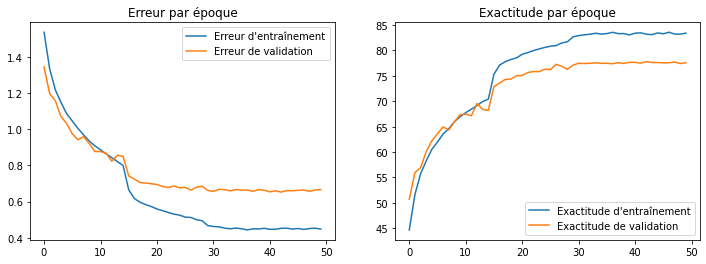

In [116]:
loss_per_epoch = []
acc_per_epoch = []
val_loss_per_epoch = []
val_acc_per_epoch = []
for epoch in history:
    loss_per_epoch.append(epoch['loss'])
    acc_per_epoch.append(epoch['acc'])
    val_loss_per_epoch.append(epoch['val_loss'])
    val_acc_per_epoch.append(epoch['val_acc'])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_per_epoch, label='Erreur d\'entraînement')
plt.plot(val_loss_per_epoch, label='Erreur de validation')
plt.title('Erreur par époque')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_per_epoch, label='Exactitude d\'entraînement')
plt.plot(val_acc_per_epoch, label='Exactitude de validation')
plt.title('Exactitude par époque')
plt.legend()
plt.show()

### Évaluer le modèle sur les données de test

#### Obtenir les prédictions

In [118]:
predictions = model.predict_generator(test_loader, has_ground_truth=True)

# Obtenir la classe ayant le plus grand score
predicted_classes = predictions.argmax(axis=1)

# Obtenir les labels test
ground_truth = test_data[:, -1].long().numpy()

Prediction steps: 469 0.90s                                            


#### Calculer la matrice de confusion

In [119]:
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]

confusion_matrix = np.zeros((output_size, output_size)).astype(int)
for i in range(len(predicted_classes)):
    confusion_matrix[ground_truth[i], predicted_classes[i]] += 1

df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)

df_cm

,Another party (please specify),Bloc Qu<e9>b<e9>cois,Conservative Party,Don't know/ Prefer not to answer,Green Party,Liberal Party,ndp,People's Party
Another party (please specify),1860,0,0,0,0,0,0,0
Bloc Qu<e9>b<e9>cois,0,1765,2,12,3,6,4,6
Conservative Party,19,55,1213,224,105,74,140,83
Don't know/ Prefer not to answer,13,52,223,933,130,300,220,37
Green Party,9,10,35,95,1562,104,109,11
Liberal Party,10,46,49,188,151,1144,229,33
ndp,9,17,68,207,128,231,1188,21
People's Party,0,0,0,0,0,0,0,1866


#### Calculer les métriques de performance

In [120]:
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix) * 100
precision = np.diag(confusion_matrix) / confusion_matrix.sum(axis=0) * 100
recall = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1) * 100
f1_score = 2 * (precision * recall) / (precision + recall) * 100

print(f"Accuracy: {accuracy:.2f}%")

df_metrics = pd.DataFrame({"Precision": precision, "Recall": recall, "F1 Score": f1_score}, index=classes)

df_metrics = df_metrics.applymap(lambda x: f"{x:.2f}%")
df_metrics

Accuracy: 76.88%


,Precision,Recall,F1 Score
Another party (please specify),96.88%,100.00%,9841.27%
Bloc Qu<e9>b<e9>cois,90.75%,98.16%,9430.94%
Conservative Party,76.29%,63.41%,6925.49%
Don't know/ Prefer not to answer,56.24%,48.90%,5231.29%
Green Party,75.13%,80.72%,7782.76%
Liberal Party,61.54%,61.84%,6168.78%
ndp,62.86%,63.56%,6320.83%
People's Party,90.71%,100.00%,9513.13%
